In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss

import os
import pandas
import numpy as np
import idx2numpy

from typing import Tuple

import matplotlib.pyplot as plt

# Hyper Parameter selection: Reproducibility and GPU



## TODO
Take HW4 and:
- adapt the code such that it runs on the GPU (5 Points) 
- adapt the code such that the results are reproducible AND we can choose our model based on `multiple seeds per hyper parameters setting`  <s>multiple runs (e.g. 5) per seed! (5 Points)</s>
  You can leave the activation functions out of the hyper parameter search!



In [140]:
class CNN(nn.Module):
    def __init__(self, activationFunc):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(in_channels=1,
                      out_channels=16,            
                      kernel_size=5,              
                      stride=1,                   
                      padding=2),                              
            activationFunc,                      
            nn.MaxPool2d(kernel_size=2)   
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            activationFunc,                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        
        self.is_conv = True
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output 
            
    
    def zero_init(self):
        for p in self.parameters():
            p.data.zero_()

In [141]:
def load_idxfile(path: str) -> np.array:
    # can we do that for all files in the folder? 
    arr = idx2numpy.convert_from_file(path)
    return arr

In [142]:
notebook_path = os.path.abspath("A4.ipynb")
folder = os.path.join(os.path.dirname(notebook_path), "idx_raw")

file_path = os.path.join(folder, "t10k-images.idx3-ubyte")
data = load_idxfile(file_path)
file_path_labels = os.path.join(folder, "t10k-labels.idx1-ubyte")
labels = load_idxfile(file_path_labels)

In [143]:
# Definition of the data set: Nothing to do here
class MNISTDset(Dataset):
    def __init__(self, images: np.array, labels: np.array) -> None:
        self.images = torch.tensor(images)/255.
        self.labels = torch.tensor(labels)
        self.num_samples = len(self.labels)
        
        # nomralize to standard deviation
        self._normalize()
        
        
    def set_num_samples(self, n:int=None) -> None:
        '''
        Restrict numbers of samples. 
        Not necessary, but sometimes useful for model testing 
        '''
        if n is None:
            self.num_samples = len(self.labels)
        else:
            assert 0 <=  n <= len(self.labels)
            self.num_samples = n
            
    def _normalize(self, mean: float=None, std: float=None):
        if std is not None: 
            assert std > 0
        '''Normalize data to nomral standard'''
        self.images = self.images - self.images.mean() if mean is None else self.images - mean 
        self.images = self.images / (self.images.std() + 1e-12) if std == None else self.images / std
        
    def __len__(self):
        ret = self.num_samples
        return ret
    
    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        image = self.images[idx]
        label = self.labels[idx]
        return image, label, idx 

In [144]:
def accuracy(out, label):
    return (out.argmax(-1) == label).float()

In [145]:
def train(model, train_loader, optimizer, loss_fun, device, epoch) -> Tuple[float, float]:
    model.to(device)
    model.train()
    
    n_batches = len(train_loader)
    for i, (image, target, idx) in enumerate(train_loader):
        image = image.to(device)
        target = target.to(device)
        # get batch size
        bs = image.shape[0]            
        # fully connected model: we need to flatten the images
        x = image.view(bs,-1) if not model.is_conv else image.view(bs,1,28,28)            
        # image to device
        x = x.to(device)
            
        # zero grads
        optimizer.zero_grad()
            
        # forward pass
        out = model(x).to(device)
            
        # calc loss and gradients
        loss = loss_fun(out, target).mean()
        loss.backward()
            
        # update
        optimizer.step()
    return loss.item()

In [146]:
def valid(model, test_loader, optimizer, loss_fun, device, epoch) -> Tuple[float, float]:
    # TODO: adapt code beolow
    model.eval()
    with torch.no_grad():
        for i, (image, target, idx) in enumerate(test_loader):
            image = data.to(device)
            target = target.to(device)

            # get batch size
            bs = image.shape[0]
                
            # fully connected model: we need to flatten the images
            x = image.view(bs,-1) if not model.is_conv else image.view(bs,1,28,28)
                
            # image to device
            x = x.to(device)
                
            # zero grads
            optimizer.zero_grad()
                
            # forward pass
            out = model(x).to(device)
                
            # calc loss and gradients
            loss = loss_fun(out, target).mean()
            loss.backward()
                
            # update
            optimizer.step()
    return loss.item()

In [147]:

# from torch.utils.data.sampler import RandomSampler

# class RandomSampler(RandomSampler):
#     r"""Samples elements randomly, without replacement.
#     Arguments:
#         data_source (Dataset): dataset to sample from
#     """

#     def __init__(self, data_source, batch_size, seed):
#         self.data_source = data_source
#         self.batch_size = batch_size
#         self.i = 0
#         self.idx = torch.randperm(len(self.data_source)).tolist ()

#     def __iter__(self):
#         self.i = 0
#         while (self.i+1)*self.batch_size < len(self.data_source):
#             yield self.idx[self.i*self.batch_size: (self.i+1)*self.batch_size]
#             self.i+=1

#     def __len__(self):
#         return len(self.data_source)

In [148]:
from torch.utils.data.sampler import RandomSampler

def setDataSetsAndLoader(batchsize, seed):
    dataCount = len(data)
    print("data count=", dataCount)

    dataTrainCount = (int) (dataCount * 0.8)
    print("80% train data split count =", dataTrainCount)


    # training data
    train_data = data[:dataTrainCount] # this will take a subset of the data till the 80% size of the numpy array
    train_labels = labels[:dataTrainCount] # same for labels
    train_dset = MNISTDset(images=train_data, labels=train_labels)
    
    gen = torch.Generator()
    gen.manual_seed(seed)
    sampler = RandomSampler(train_dset, False, batchsize, generator=gen)
    train_loader = DataLoader(dataset=train_dset, sampler=sampler, num_workers=0)

    print("actual train_data count =", train_data.size)
    print("actual train_labels count =", train_labels.size)

    # val data
    val_data = data[dataTrainCount:] # takes the last 20% of the numpy array as validation set
    val_labels = labels[dataTrainCount:] # same for labels
    val_dset = MNISTDset(images=val_data, labels=val_labels)
    #sampler = RandomSampler(val_dset, batchsize)
    #val_loader = DataLoader(dataset=val_dset, sampler=sampler, num_workers=0)

    print("actual val_data count=", val_data.size)
    print("actual val_labels count =", val_labels.size)

In [149]:


def main( learning_rates:list, batch_sizes:list, activation_function, seeds):
    num_epochs = 20
    bestModel = None
    bestAcc = 0
    
    for batchSize in batch_sizes:
    
        for learningRate in learning_rates:       
            for seed in seeds:

                # Sets the datasets + Loader with batchsize and see for the sampler
                setDataSetsAndLoader(batchSize, seed)
                     
                model = CNN(activation_function)
                model.zero_init()
                print(model)
                optimizer = optim.Adam(params=model.parameters(), lr=learningRate)
                ce_loss = CrossEntropyLoss()

                # device = 'cuda' if torch.cuda.is_available() else 'cpu' 
                device = 'cuda'
                model = model.to(device)

                tr_loss = []
                tr_acc = []
                ev_loss = []
                ev_acc = []
                for epoch in range(num_epochs):
                    loss = train(model, train_loader, optimizer, ce_loss, device, epoch)
                    tr_loss.append(loss)


                    # calculate accuracy
                    x, label, idx = train_dset[:]
                    x, label = x.to(device), label.to(device),
                    x = x.view(train_dset.__len__(),1,28,28)
                    out = model(x)
                    acc_ = (out.argmax(-1) == label).float().sum()/len(label)
                    
                    # need to get tensor data to cpu to make them plotable later on
                    tr_acc.append(acc_.cpu())


                    x, label, idx = val_dset[:] 
                    x, label = x.to(device), label.to(device)
                    x = x.view(val_dset.__len__(),1,28,28) 
                    x.to(device)
                    
                    model.eval()
                    out = model(x)
                    acc_ = (out.argmax(-1) == label).float().sum()/len(label)

                    # need to get tensor data to cpu to make them plotable later on
                    ev_acc.append(acc_.cpu())

                    print(f'epoch [{epoch+1}/{num_epochs}]: train loss = {loss:.5f}, train acc = {tr_acc[-1]:.5f}, val acc = {ev_acc[-1]:.5f}')

                plt.plot(tr_loss, label='train loss')
                plt.legend()
                plt.show()

                plt.plot(tr_acc, label='train accuracy')
                plt.plot(ev_acc, label='eval accuracy')
                
                hihgest_acc = sum(ev_acc) / len(ev_acc)
                # remember best model
                if(hihgest_acc > bestAcc):
                    print(f'this Model is better than best so far. Old eval acc: {bestAcc}, this eval acc: {ev_acc}')
                    bestAcc = hihgest_acc
                    bestModel = model
                
                plt.title('acc')
                plt.legend()
                plt.show()
    return bestModel

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.24479, train acc = 0.10163, val acc = 0.10750
epoch [2/20]: train loss = 2.35887, train acc = 0.09838, val acc = 0.09350
epoch [3/20]: train loss = 2.14347, train acc = 0.10163, val acc = 0.10750
epoch [4/20]: train loss = 2.25869, train acc = 0.09850, val acc = 0.09700
epoch [5/20]: train loss = 2.33866, train acc =

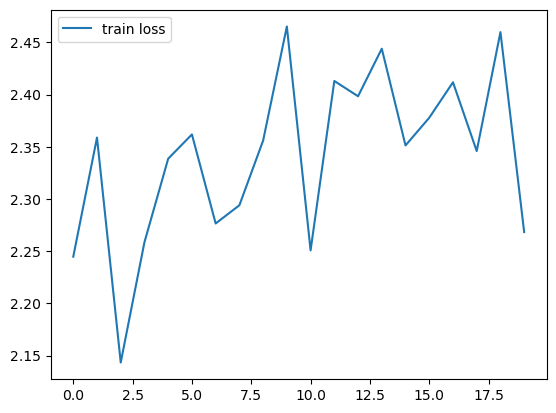

this Model is better than best so far. Old eval acc: 0, this eval acc: [tensor(0.1075), tensor(0.0935), tensor(0.1075), tensor(0.0970), tensor(0.1035), tensor(0.0955), tensor(0.0955), tensor(0.0935), tensor(0.1035), tensor(0.1150), tensor(0.0990), tensor(0.1150), tensor(0.1035), tensor(0.1035), tensor(0.1075), tensor(0.0970), tensor(0.0970), tensor(0.1150), tensor(0.1010), tensor(0.1075)]


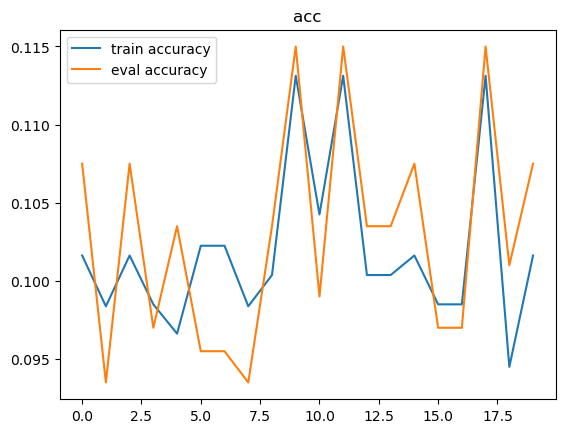

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.22593, train acc = 0.09850, val acc = 0.09700
epoch [2/20]: train loss = 2.33168, train acc = 0.10225, val acc = 0.09550
epoch [3/20]: train loss = 2.23852, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.35541, train acc = 0.10225, val acc = 0.09550
epoch [5/20]: train loss = 2.36532, train acc =

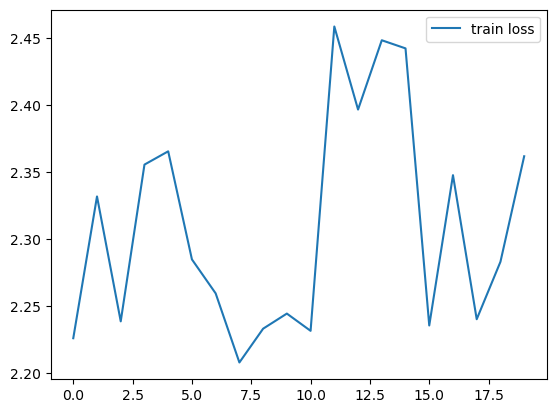

this Model is better than best so far. Old eval acc: 0.10289999097585678, this eval acc: [tensor(0.0970), tensor(0.0955), tensor(0.1150), tensor(0.0955), tensor(0.1075), tensor(0.1150), tensor(0.1150), tensor(0.1075), tensor(0.0935), tensor(0.0935), tensor(0.1150), tensor(0.0935), tensor(0.0990), tensor(0.1150), tensor(0.1150), tensor(0.0990), tensor(0.1035), tensor(0.1035), tensor(0.1075), tensor(0.1150)]


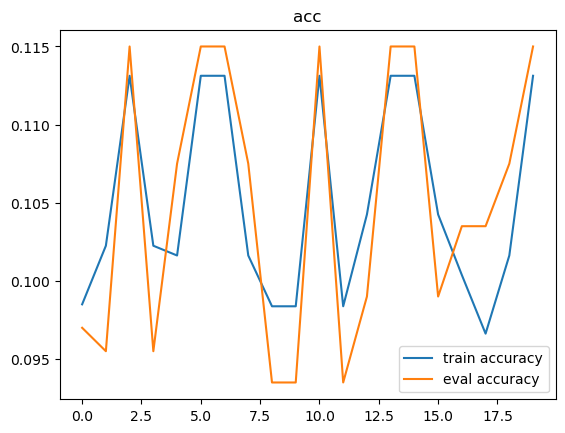

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.29958, train acc = 0.09838, val acc = 0.09350
epoch [2/20]: train loss = 2.37564, train acc = 0.10425, val acc = 0.09900
epoch [3/20]: train loss = 2.39723, train acc = 0.09850, val acc = 0.09700
epoch [4/20]: train loss = 2.22430, train acc = 0.10038, val acc = 0.10350
epoch [5/20]: train loss = 2.47229, train acc =

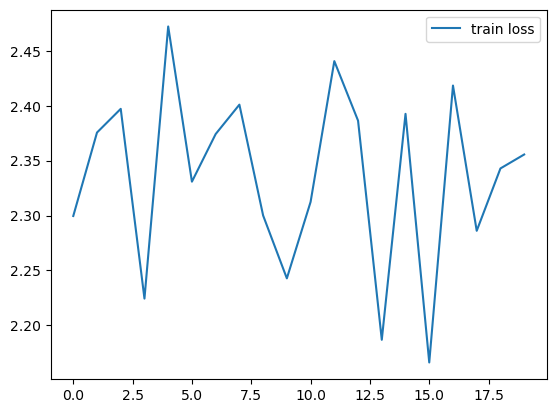

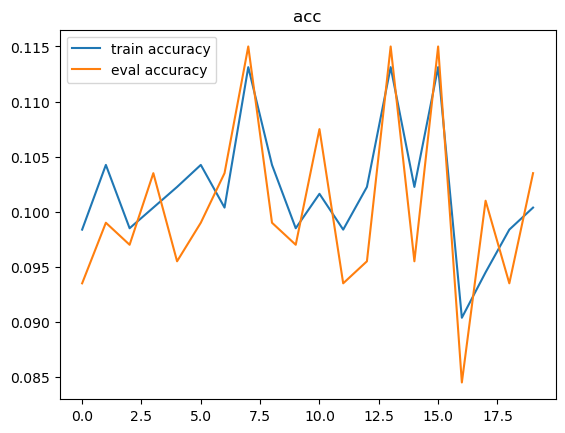

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.28400, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.34106, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.30323, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.32767, train acc = 0.10425, val acc = 0.09900
epoch [5/20]: train loss = 2.28833, train acc =

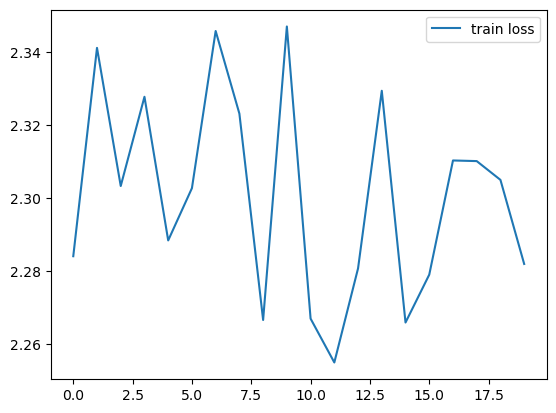

this Model is better than best so far. Old eval acc: 0.10505000501871109, this eval acc: [tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.0990), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1035), tensor(0.0990), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.0990), tensor(0.1150), tensor(0.0990), tensor(0.1150), tensor(0.0990), tensor(0.0970)]


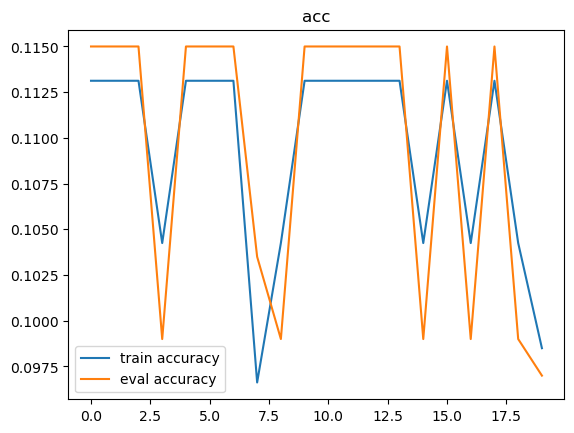

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.31033, train acc = 0.09663, val acc = 0.10350
epoch [2/20]: train loss = 2.28805, train acc = 0.10425, val acc = 0.09900
epoch [3/20]: train loss = 2.31965, train acc = 0.10163, val acc = 0.10750
epoch [4/20]: train loss = 2.31340, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.27190, train acc =

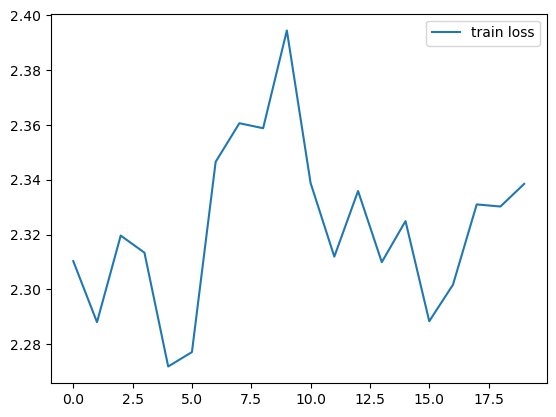

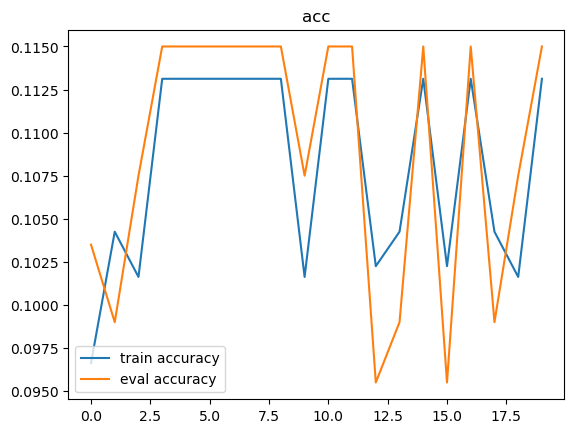

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.32606, train acc = 0.10163, val acc = 0.10750
epoch [2/20]: train loss = 2.29541, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.30525, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.35328, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.34641, train acc =

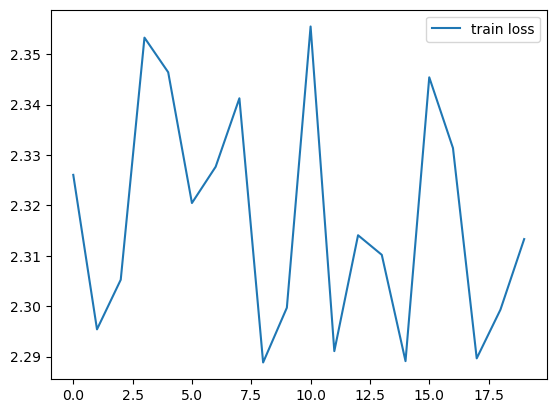

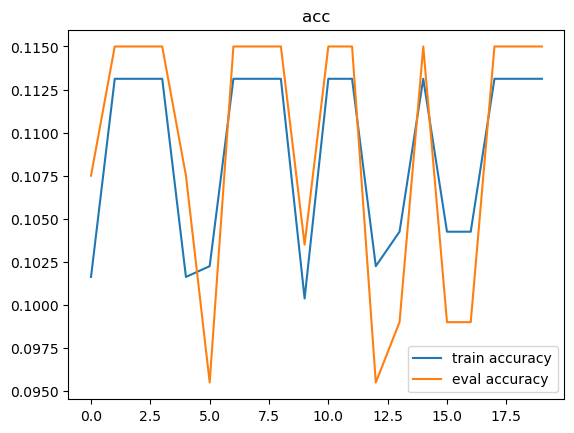

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.29984, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.31844, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.27054, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.29713, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.30248, train acc =

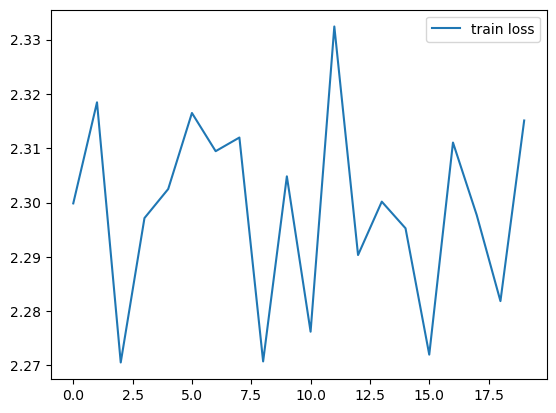

this Model is better than best so far. Old eval acc: 0.10952500998973846, this eval acc: [tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150), tensor(0.1150)]


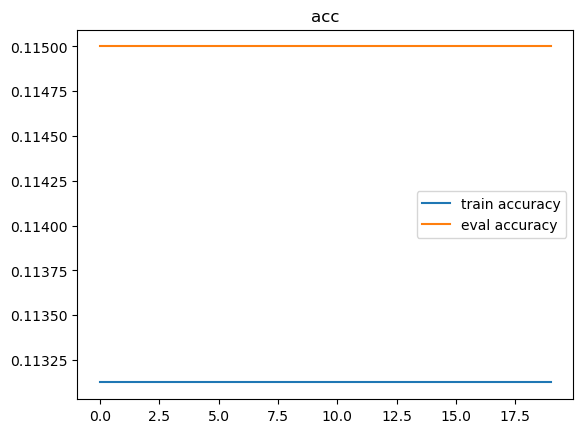

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.28508, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.31014, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.31960, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.31274, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.28041, train acc =

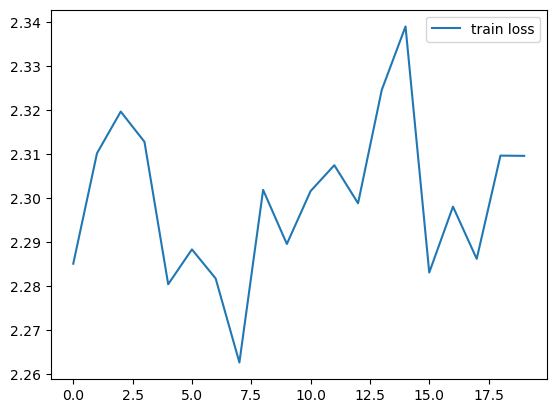

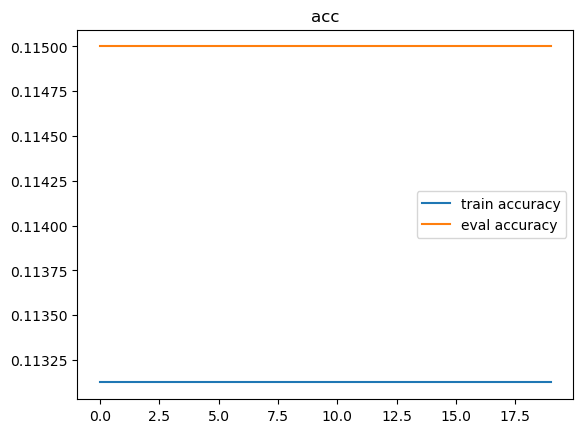

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.30541, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.29503, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.29234, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.29250, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.28629, train acc =

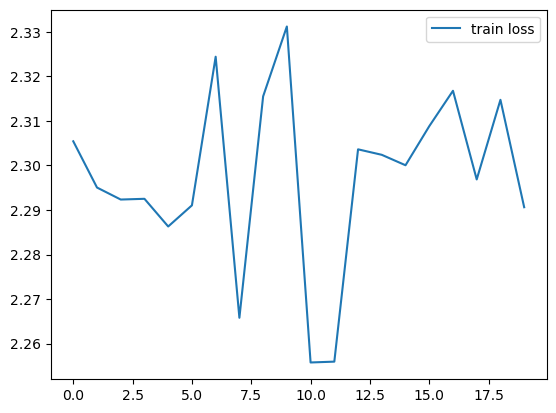

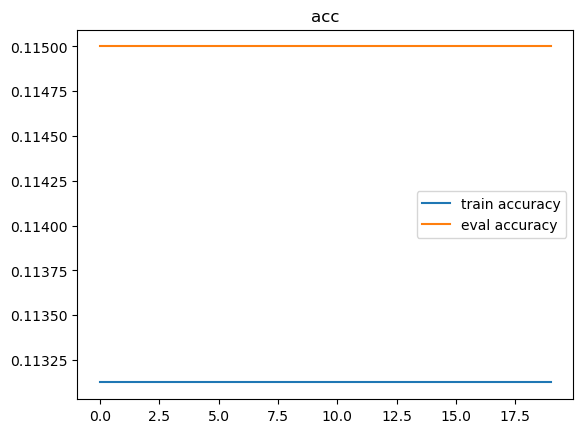

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.30099, train acc = 0.10425, val acc = 0.09900
epoch [2/20]: train loss = 2.51605, train acc = 0.10038, val acc = 0.10350
epoch [3/20]: train loss = 2.42235, train acc = 0.10425, val acc = 0.09900
epoch [4/20]: train loss = 2.23603, train acc = 0.09450, val acc = 0.10100
epoch [5/20]: train loss = 2.33257, train acc =

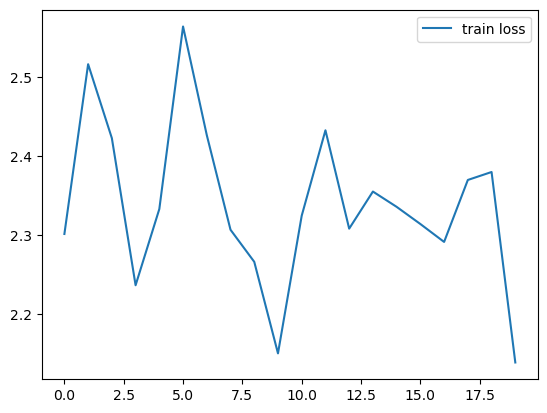

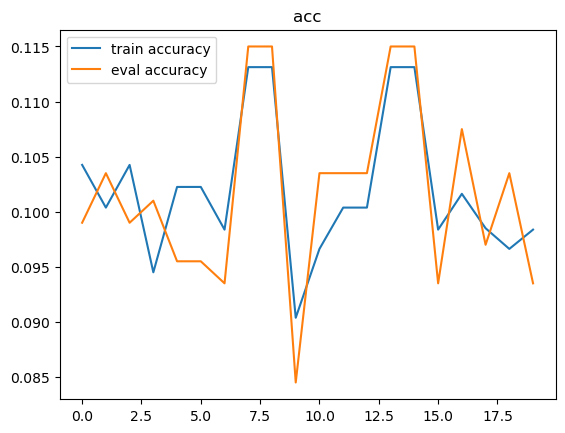

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.26213, train acc = 0.10038, val acc = 0.10350
epoch [2/20]: train loss = 2.27944, train acc = 0.10163, val acc = 0.10750
epoch [3/20]: train loss = 2.37067, train acc = 0.10038, val acc = 0.10350
epoch [4/20]: train loss = 2.36726, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.37085, train acc =

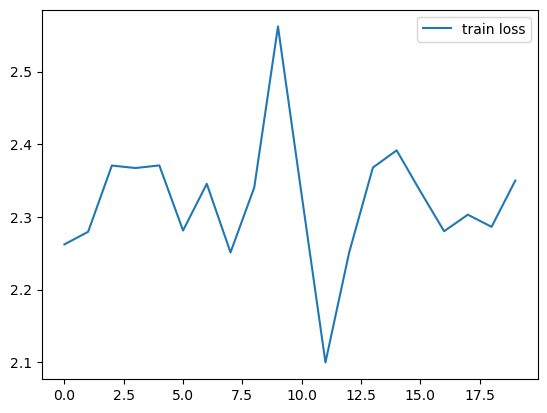

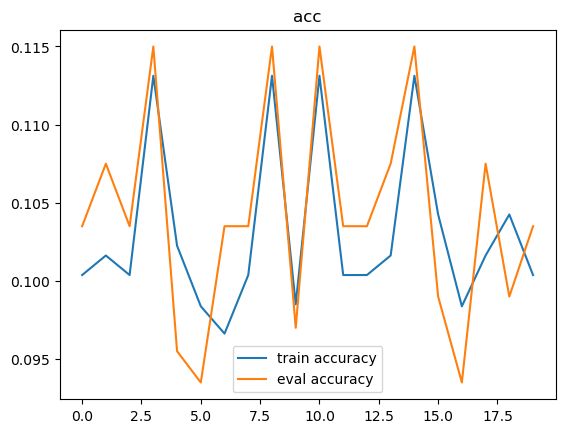

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.30827, train acc = 0.10163, val acc = 0.10750
epoch [2/20]: train loss = 2.18894, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.30470, train acc = 0.09850, val acc = 0.09700
epoch [4/20]: train loss = 2.34837, train acc = 0.10163, val acc = 0.10750
epoch [5/20]: train loss = 2.30965, train acc =

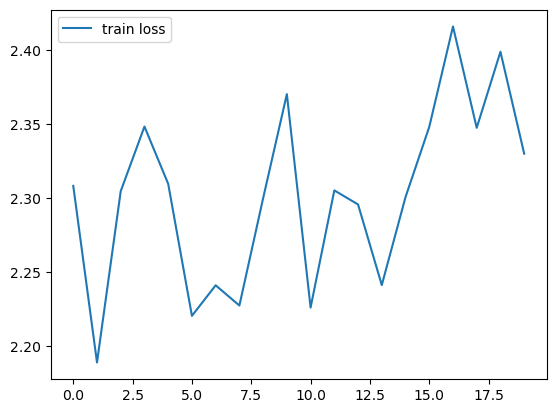

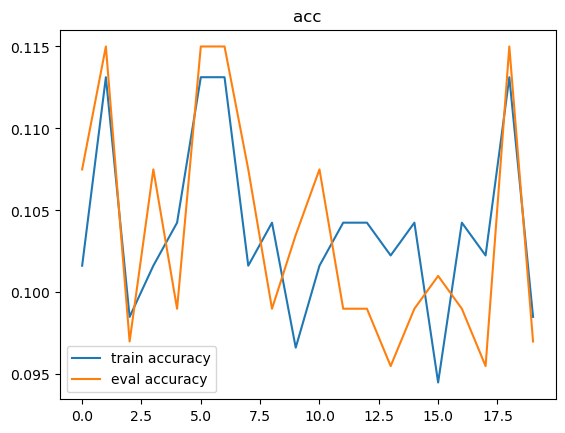

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.32337, train acc = 0.10425, val acc = 0.09900
epoch [2/20]: train loss = 2.32125, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.32505, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.26324, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.33309, train acc =

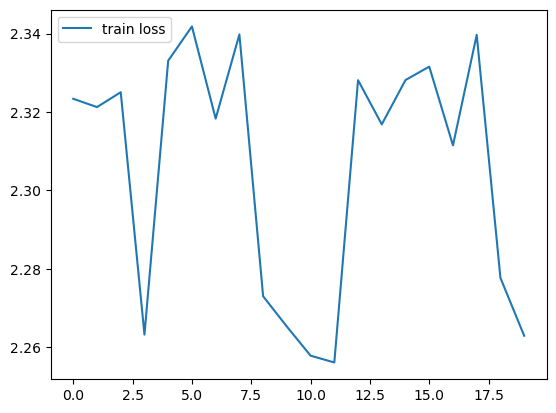

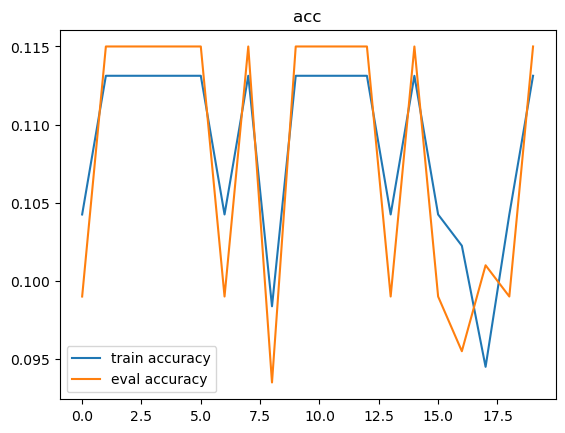

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.29406, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.26715, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.20600, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.31143, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.31067, train acc =

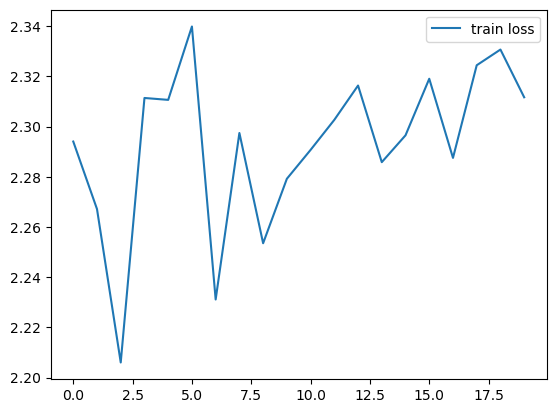

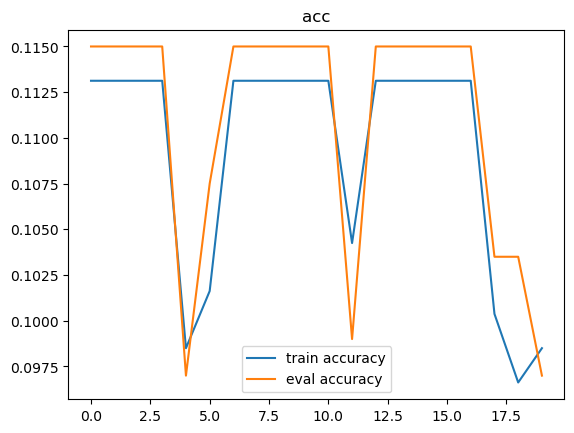

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.27418, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.28095, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.38651, train acc = 0.10425, val acc = 0.09900
epoch [4/20]: train loss = 2.28231, train acc = 0.10225, val acc = 0.09550
epoch [5/20]: train loss = 2.27758, train acc =

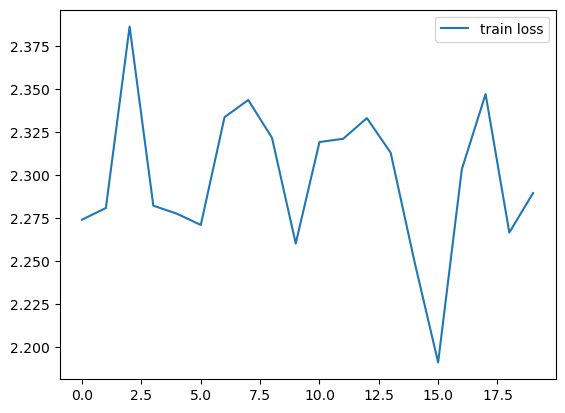

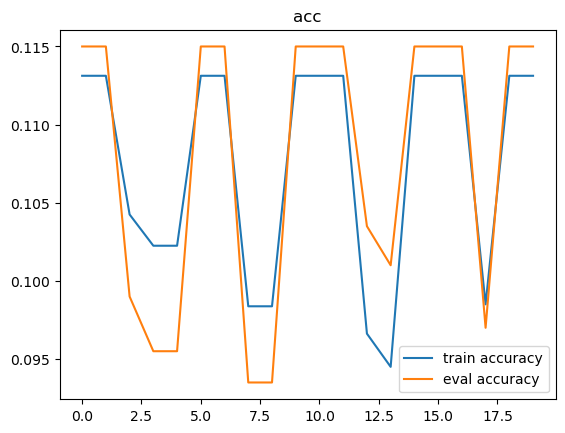

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.31644, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.31760, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.31784, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.31400, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.29102, train acc =

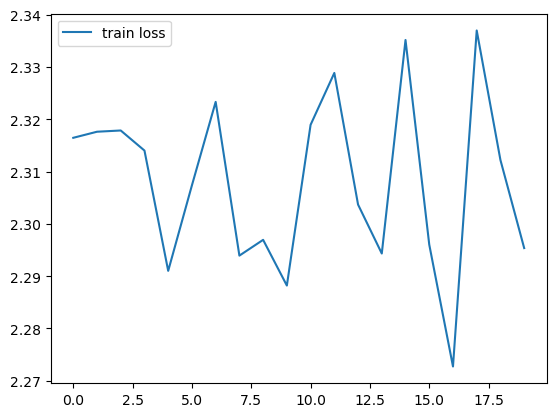

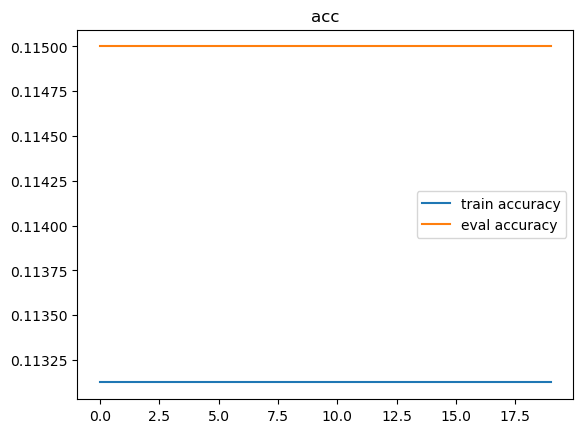

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.30232, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.32171, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.29361, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.31260, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.34686, train acc =

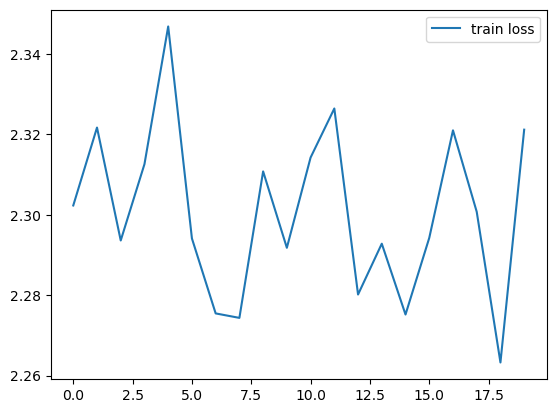

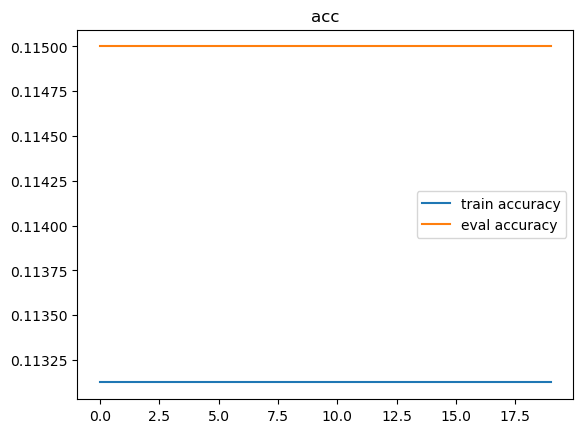

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.31385, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.33235, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.30416, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.31020, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.30220, train acc =

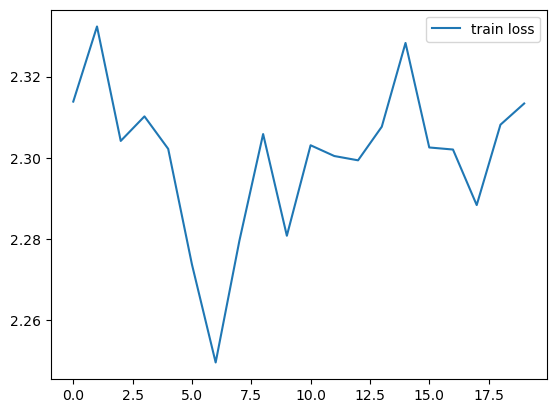

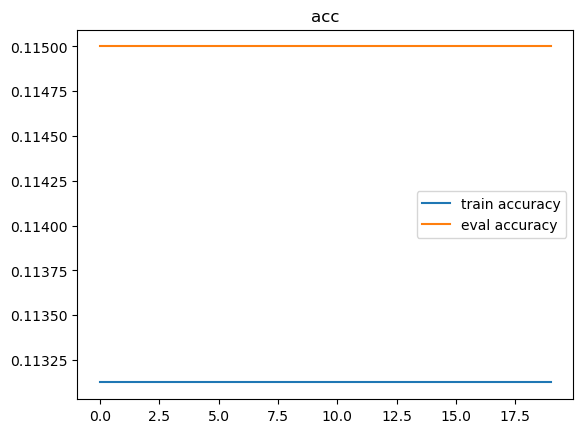

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.27874, train acc = 0.10425, val acc = 0.09900
epoch [2/20]: train loss = 2.20442, train acc = 0.10425, val acc = 0.09900
epoch [3/20]: train loss = 2.26632, train acc = 0.10425, val acc = 0.09900
epoch [4/20]: train loss = 2.47888, train acc = 0.09038, val acc = 0.08450
epoch [5/20]: train loss = 2.43474, train acc =

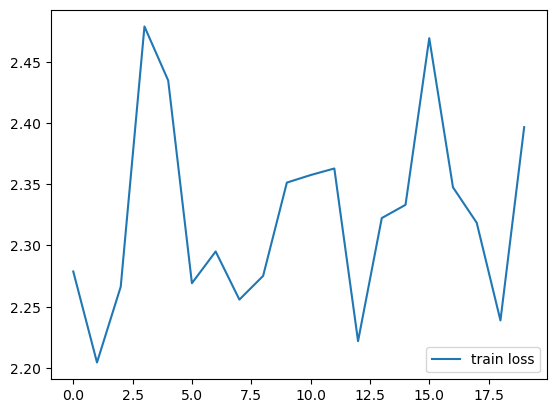

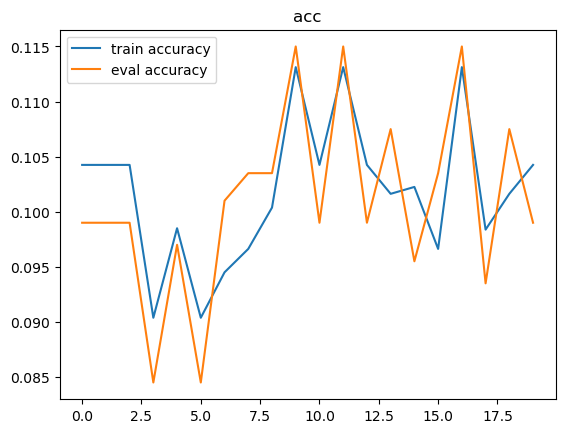

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.40457, train acc = 0.09838, val acc = 0.09350
epoch [2/20]: train loss = 2.26974, train acc = 0.09663, val acc = 0.10350
epoch [3/20]: train loss = 2.32628, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.42920, train acc = 0.09838, val acc = 0.09350
epoch [5/20]: train loss = 2.38219, train acc =

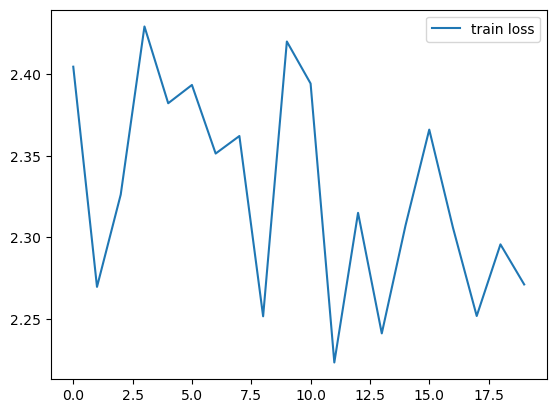

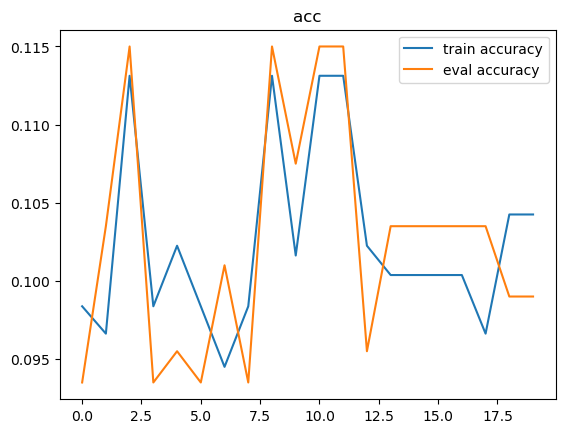

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.27795, train acc = 0.09038, val acc = 0.08450
epoch [2/20]: train loss = 2.24169, train acc = 0.09663, val acc = 0.10350
epoch [3/20]: train loss = 2.31137, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.41711, train acc = 0.10225, val acc = 0.09550
epoch [5/20]: train loss = 2.47368, train acc =

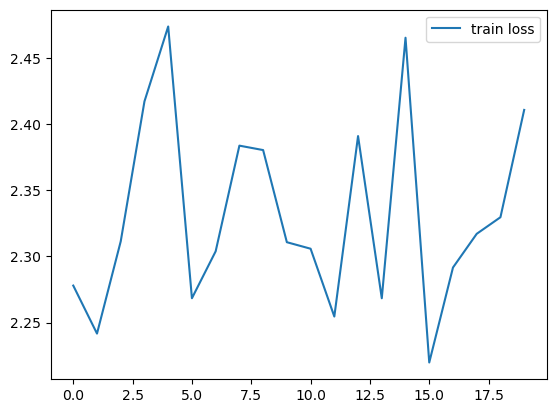

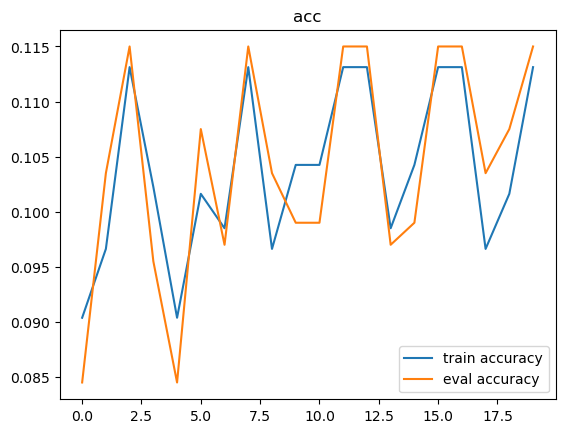

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.24679, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.31403, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.30456, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.28040, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.32021, train acc =

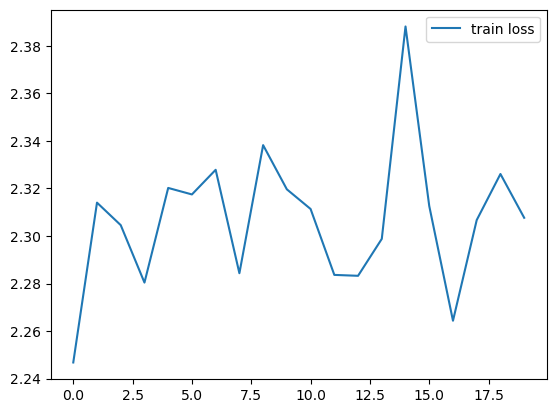

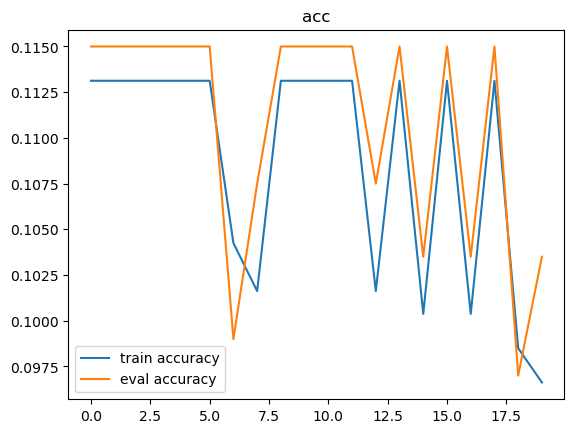

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.32084, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.31067, train acc = 0.10163, val acc = 0.10750
epoch [3/20]: train loss = 2.31006, train acc = 0.10163, val acc = 0.10750
epoch [4/20]: train loss = 2.35212, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.29531, train acc =

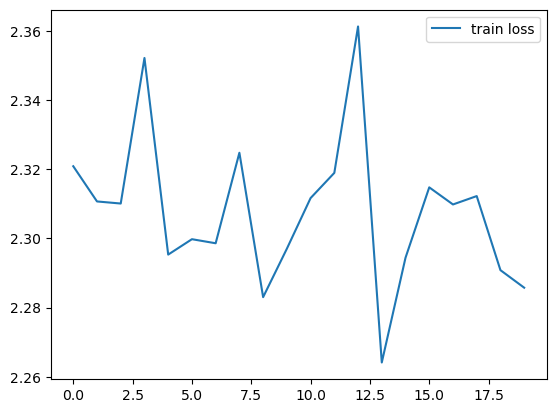

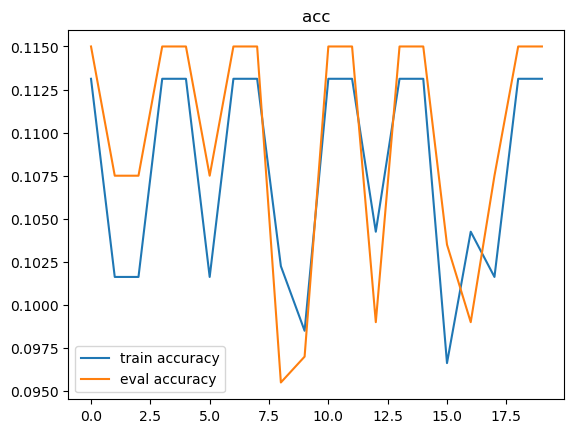

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.26246, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.34621, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.27306, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.29536, train acc = 0.10225, val acc = 0.09550
epoch [5/20]: train loss = 2.31169, train acc =

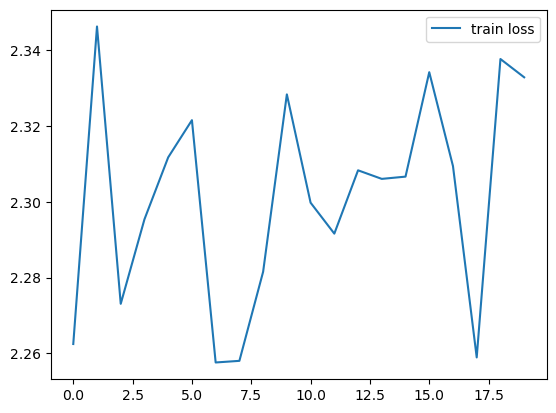

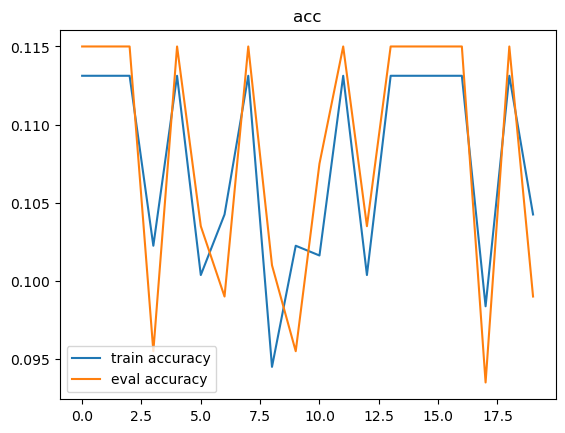

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.31782, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.28237, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.29075, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.32875, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.29548, train acc =

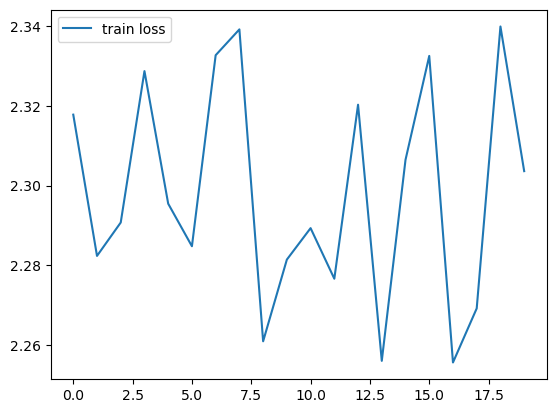

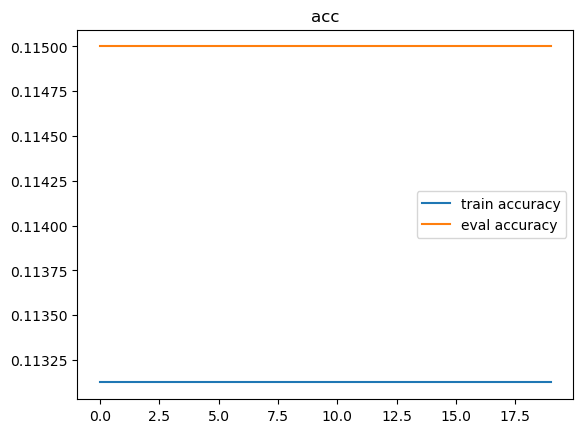

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.27537, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.27780, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.30619, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.29179, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.31055, train acc =

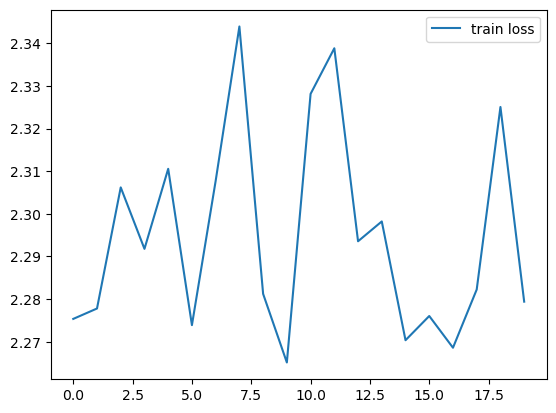

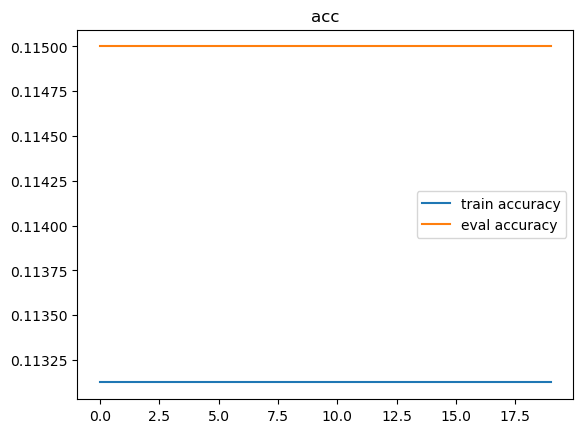

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.30999, train acc = 0.11313, val acc = 0.11500
epoch [2/20]: train loss = 2.33089, train acc = 0.11313, val acc = 0.11500
epoch [3/20]: train loss = 2.32205, train acc = 0.11313, val acc = 0.11500
epoch [4/20]: train loss = 2.30437, train acc = 0.11313, val acc = 0.11500
epoch [5/20]: train loss = 2.31313, train acc =

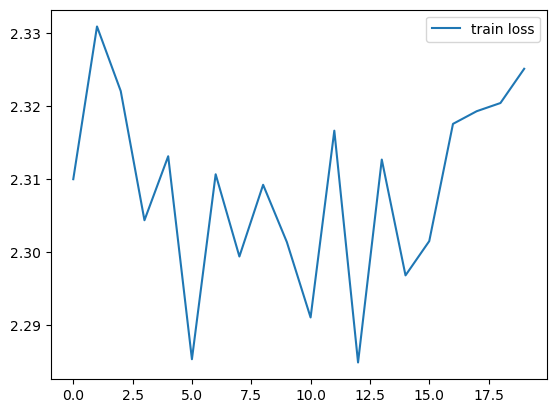

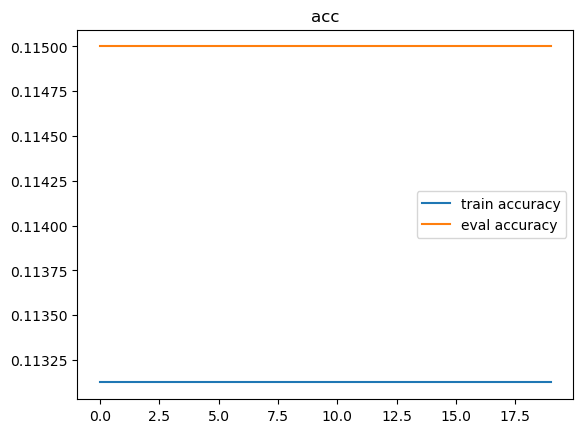

In [150]:
learning_rates = [0.1, 0.01, 0.001] 
batch_size = [20, 50, 100]
seeds = [42,420,1000]
model = main(learning_rates, batch_size, nn.ReLU(), seeds)